# ImageCLEF Medical Caption Task 2019

The Image CLEF 2019 Concept Detection Task is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by Unified Medical Language System (UMLS) concept IDs.

The AUEB NLP Group won the competition with this paper. This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('ggplot')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


Read the labels

In [3]:
string_consepts = 'ImageCLEF2019/string_concepts.csv'
train_consepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_consepts, sep='\t', header=None)
train_con = pd.read_csv(train_consepts)
val_con = pd.read_csv(val_concepts)

Let's plot some images

In [4]:
training_set = 'ImageCLEF2019/training-set/'
test_set = 'ImageCLEF2019/test-set/'
validation_set = 'ImageCLEF2019/validation-set/'

In [7]:
train = []

time1 = time.time()   # to measure time taken

# Load in the images
for filepath in os.listdir(training_set):
    instances = cv2.imread(training_set + filepath, 0)
    train.append(instances)
    
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# train = np.array(train, dtype="float") / 255.0

Time taken: 167.3 seconds


In [8]:
train[2].shape

(504, 539)

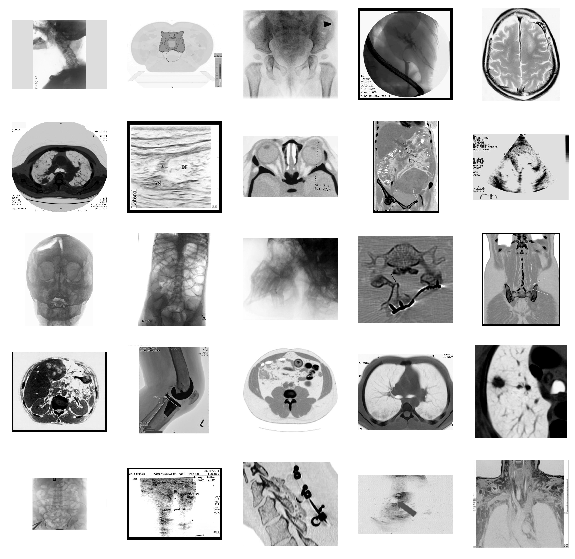

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])

Resources:
    
https://github.com/JNYH/Project_Kojak